#Описание
Данная тетрадка содержит описание данных задачи.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#time_series.csv
Данный файл содержит временные ряды истории обращений к файлам за 78 недель и их метки. Метка **0** - популярные файлы, **1** - непопулярные файлы. Важно надежно определять непопулярные файлы.


###Чтение файла.

In [2]:
lhcb_data = pd.read_csv('/Users/mikhail91/Documents/DataPopularity/Data/popularity-728days.csv')
lhcb_data.irow(range(0,3))

,Name,Configuration,ProcessingPass,FileType,Type,Creation-week,NbLFN,LFNSize,NbDisk,DiskSize,...,95,96,97,98,99,100,101,102,103,104
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08-MINBIAS-FIRST-14-NB/Stripping12d,MINIBIAS.DST,1,104591,67,0.317900,134,0.635799,...,12687,12687,12687,12687,12687,12687,12687,12687,12687,12687
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08/Stripping14,BHADRON.DST,1,104607,227,0.649204,980,2.819260,...,1631,1631,1631,1631,1631,1631,1631,1631,1631,1631
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08/Stripping14,CALIBRATION.DST,1,104607,355,1.370105,355,1.370105,...,0,0,0,474,708,708,708,708,708,708


In [3]:
from datapop.LHCb import DataPreprocessor
data = DataPreprocessor(data=lhcb_data).get_preprocessed_data()
data.irow(range(0,3))

,ID,DiskSize,Creation,First,StartTime,Now,1,2,3,4,...,95,96,97,98,99,100,101,102,103,104
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0.635799,104591,104670,104660,104764,0,0,0,0,...,0,0,0,0,0,0,0,0,0,134
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,2.819260,104607,104676,104660,104764,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,1.370105,104607,104666,104660,104764,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#Отбор данных

In [4]:
selection = data[[str(i) for i in range(21, 53)]]
selected_data = data[selection.sum(axis=1)!=0]

#Препроцессинг данных

In [5]:
def add_diff(X):
    X_copy = X.copy()
    for i in range(0,X_copy.shape[1]-1):
        diff = np.array(X_copy[:,i+1] - X_copy[:,i], ndmin=2).T
        X = np.concatenate((X, diff), axis=1)
    return X

def diff(X):
    X_copy = X.copy()
    X_new = None
    for i in range(0,X_copy.shape[1]-1):
        diff = np.array(X_copy[:,i+1] - X_copy[:,i], ndmin=2).T
        if X_new==None:
            X_new=diff
        X_new = np.concatenate((X_new, diff), axis=1)
    return X_new

def sum_window(X, w):
    X_new = None
    i = X.shape[1]
    while i-w >=0:
        wsum = np.array(X[:, range(i-w, i)].sum(axis=1), ndmin=2).T
        i = i - w
        if X_new==None:
            X_new = wsum
        else:
            X_new = np.concatenate((X_new, wsum), axis=1)
    return X_new

def cumsum(X):
    return X.cumsum(axis=1)

def rolling_sum(X, w):
    X_new = None
    i = X.shape[1]
    while i-w >=0:
        wsum = np.array(X[:, range(i-w, i)].sum(axis=1), ndmin=2).T
        i = i - 1
        if X_new==None:
            X_new = wsum
        else:
            X_new = np.concatenate((X_new, wsum), axis=1)
    return X_new

In [565]:
from sklearn.linear_model import Ridge

class MyAR(object):
    def __init__(self, n=None, horizont=None, avg=False):
        self.n = n
        self.horizont = horizont
        self.avg = avg
        self.lr = None
        
    def _data_fit(self, X, n, horizont, avg):
        X_new = []
        y_new = []
        
        for i in range(0, len(X)-n-horizont-1):
            X_new.append( X[i:i+n] )
            if avg==False:
                y_new.append( X[i+n+horizont-1] )
            elif avg==True:
                y_new.append( X[i+n:i+n+horizont].mean() )
        
        return np.array(X_new), np.array(y_new)
    
    def _data_predict(self, X, n):
        X_new = []
        
        for i in range(0, len(X)-n-1):
            X_new.append( X[i:i+n] )
        
        return np.array(X_new)
        
    def fit(self, X):
        X_new, y_new = self._data_fit(X, self.n, self.horizont, self.avg)
        
        lr = Ridge(alpha=1, fit_intercept=True, normalize=True, solver='auto')
        lr.fit(X_new, y_new)
        
        self.lr = lr
        return X_new, y_new
    
    def predict(self, X):
        X_new = self._data_predict(X, self.n)
        
        return self.lr.predict(X_new)
    
def ar_transform(X):
    ar = MyAR(n=4, horizont=3, avg=False)
    X_ar = []
    for i in range(0, X.shape[0]):
        X_new, y_new = ar.fit(X[i,:])
        y_pred = ar.predict(X[i,:])
        x_ar = np.concatenate( (y_pred, y_pred[0:len(y_new)] - y_new) )
        X_ar.append(x_ar)
    return np.array(X_ar)

In [540]:
X_ts = selected_data[[str(i) for i in range(1+0, 53+0)]].astype(np.float).values
Y_ts = (((selected_data[[str(i) for i in range(53+0, 79+0)]]).sum(axis=1)>0)*1).astype(np.float).values

X_ts1 = sum_window(X_ts, 5)
X_ts2 = ar_transform(X_ts)
X_ts = np.concatenate( (X_ts1, X_ts2), axis=1 )

/Users/mikhail91/.virtualenvs/rep_0_6_2/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [542]:
X_ts.shape

(2840, 17)

#Картинки

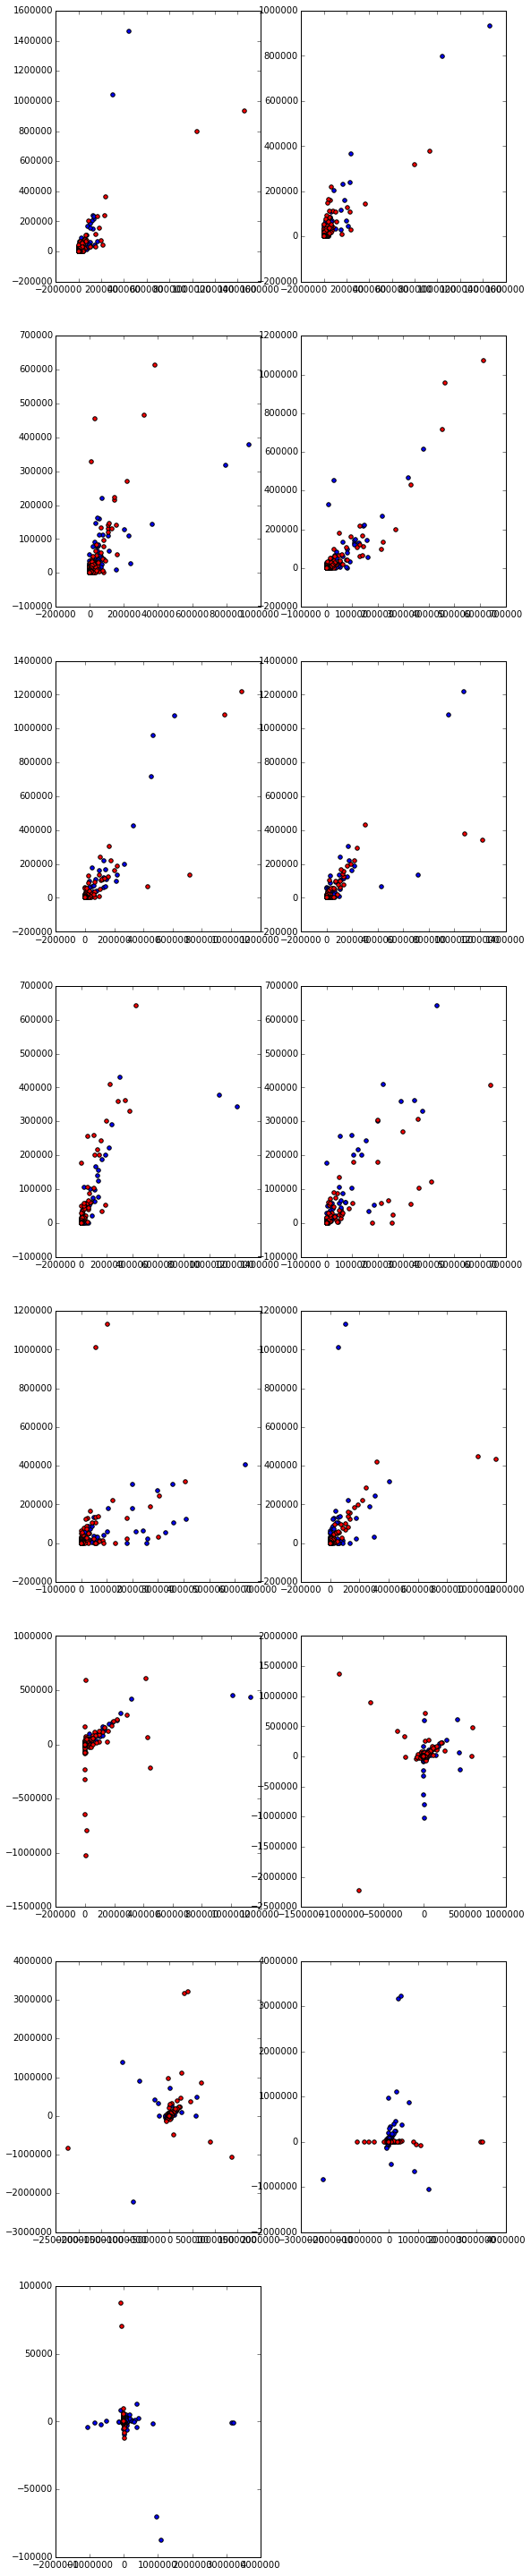

In [543]:
plt.figure(figsize=(9,3*X_ts.shape[1]))
#plt.subplots_adjust( hspace=.5)
for i in range(1, X_ts.shape[1]-1):
    plt.subplot(X_ts.shape[1]//2, 2, i)
    plt.scatter(X_ts[:, i-1], X_ts[:,i], c='b')
    plt.scatter(X_ts[:, i], X_ts[:,i+1], c='r')
plt.show()

#Применение классификатора

In [544]:
from sklearn.cross_validation import KFold

def Indexes_inverse(indexes):
    new_indexes = range(0,len(indexes))
    for i in range(0, len(indexes)):
        new_indexes[int(indexes[i])]=i
    return new_indexes

def KFold_predict_proba(estimator, X, Y, k):
    indexes = np.array([])
    Y_predict_proba = np.empty((0,2))
    kfold = KFold(n=X.shape[0], n_folds=k, random_state=42, shuffle=True)
    for train_index, test_index in kfold:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        #sample_weight = 1. + 1.*Y_train/(Y_train.sum()/float(len(Y_train)-Y_train.sum()))
        indexes = np.concatenate((indexes, test_index), axis=0)
        estimator.fit(X_train, Y_train)
        Y_predict_proba_test = estimator.predict_proba(X_test)
        Y_predict_proba = np.concatenate((Y_predict_proba, Y_predict_proba_test), axis=0)
    new_indexes = Indexes_inverse(indexes)
    return Y_predict_proba[list(new_indexes)]

In [545]:
%%time
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

estimator_ts = GradientBoostingClassifier(learning_rate=0.02, n_estimators=2500, max_depth=6, subsample=0.8)
Y_ts_proba = KFold_predict_proba(estimator=estimator_ts, X=X_ts, Y=Y_ts, k=3)

CPU times: user 48.7 s, sys: 89.9 ms, total: 48.8 s
Wall time: 49 s


Значимость признаков

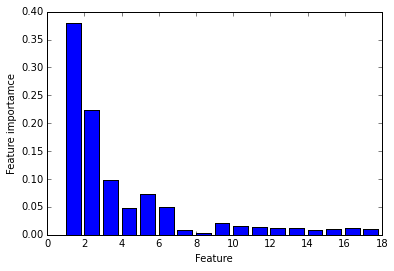

In [546]:
feature_imp = estimator_ts.feature_importances_
plt.bar(range(1,X_ts.shape[1]+1), feature_imp)
plt.xlabel('Feature')
plt.ylabel('Feature importamce')
plt.show()

Строим ROC кривую.

ROC AUC is  0.854595261411


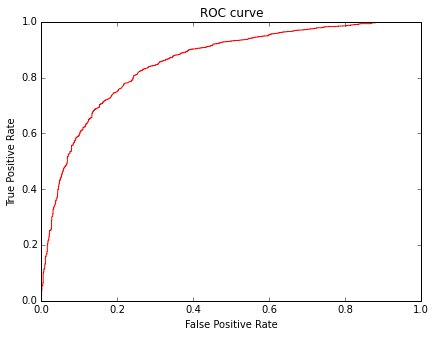

In [547]:
from sklearn.metrics import roc_curve, auc

fpr_ts, tpr_ts, _ = roc_curve(Y_ts, Y_ts_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_ts = auc(fpr_ts, tpr_ts)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(fpr_ts, tpr_ts)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print 'ROC AUC is ', roc_auc_ts

Запишем baseline 1.

In [548]:
# bs1 = pd.DataFrame()
# bs1['fpr_ts'] = fpr_ts
# bs1['tpr_ts'] = tpr_ts
# bs1.to_csv('baseline1.csv')

###Тест на новых данных

###Препроцессинг данных

In [561]:
X_test = selected_data[[str(i) for i in range(1+1, 53+1)]].astype(np.float).values
Y_test = (((selected_data[[str(i) for i in range(53+1, 79+1)]]).sum(axis=1)>0)*1).astype(np.float).values

X_test1 = sum_window(X_test, 5)
X_test2 = ar_transform(X_test1)
X_test = np.concatenate( (X_test1, X_test2), axis=1 )

/Users/mikhail91/.virtualenvs/rep_0_6_2/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [562]:
%%time

Y_test_proba = estimator_ts.predict_proba(X_test)

CPU times: user 184 ms, sys: 437 µs, total: 184 ms
Wall time: 184 ms


###Сравнение с baselines.

In [563]:
baseline1 = pd.read_csv('baseline1.csv')

ROC AUC is  0.854595261411


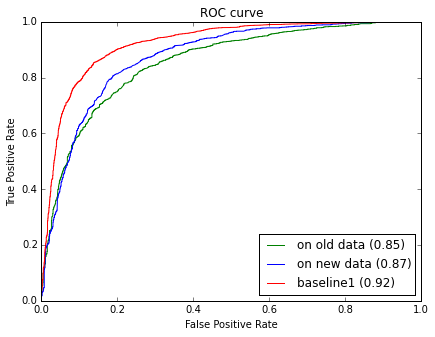

In [564]:
from sklearn.metrics import roc_curve, auc

fpr_ts, tpr_ts, _ = roc_curve(Y_ts, Y_ts_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_ts = auc(fpr_ts, tpr_ts)

fpr_test, tpr_test, _ = roc_curve(Y_test, Y_test_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_test = auc(fpr_test, tpr_test)

roc_auc_base = auc(baseline1['fpr_ts'].values, baseline1['tpr_ts'].values)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(fpr_ts, tpr_ts, label='on old data (%.2f)' % roc_auc_ts, c='g')
plt.plot(fpr_test, tpr_test, label='on new data (%.2f)' % roc_auc_test, c='b')
plt.plot(baseline1['fpr_ts'].values, baseline1['tpr_ts'].values, label='baseline1 (%.2f)' % roc_auc_base, c='r')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
print 'ROC AUC is ', roc_auc_ts